# Pixel Densities

> In the ocean community, we often operator in the Fourier domain. 
This is useful for assessing the quality of our models and it can also be useful for learning.
In this notebook, we showcase how oceanbench has two fundamental transformations that are useful for both cases: isotropic and spacetime Fourier transformations.

In [1]:
import autoroot
import typing as tp
from dataclasses import dataclass
import numpy as np
import pandas as pd
import xarray as xr
import einops
from metpy.units import units
import pint_xarray
import xarray_dataclasses as xrdataclass
from oceanbench._src.datasets.base import XRDABatcher
from oceanbench._src.geoprocessing.spatial import transform_360_to_180
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2


In [2]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/4DVarNet

2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadir_GF_GF.nc
2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc


In [3]:
file = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/4DVarNet/2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc"
# file = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/MIOST/2020a_SSH_mapping_NATL60_MIOST_swot_en_j1_tpn_g2.nc"
# file = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/DUACS/ssh_DUACS_swot_4nadir.nc"
# file = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/BFNQG/2020a_SSH_mapping_NATL60_BFN_Steady_State_QG1L_swot_en_j1_tpn_g2.nc"
file_ref = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
!ls $file

/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/4DVarNet/2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc


In [4]:
# # Domain for analysis: Gulfstream
# time_min = numpy.datetime64('2012-10-22')                # domain min time
# time_max = numpy.datetime64('2012-12-03')                # domain max time
# lon_min = -64.975                                        # domain min lon
# lon_max = -55.007                                        # domain max lon
# lat_min = 33.025                                         # domain min lat
# lat_max = 42.9917                                        # domain max lat

In [5]:
def open_ssh_results(file, variable="ssh_mod"):
    
    da = xr.open_dataset(file, decode_times=True)
    
    da = da.sortby("time")
    
    da = da.rename({variable: "ssh"})
    
    da = da.sel(
        time=slice("2012-10-22", "2012-12-01"),
        lon=slice(-64.975, -55.007),
        lat=slice(33.025, 42.9917),
        drop=True
    )
    
    da = da.resample(time="1D").mean()
    
    return da

def open_ssh_reference(file, variable="gssh"):
    da = xr.open_dataset(file, decode_times=False)
    da["time"] = pd.to_datetime(da.time)
    da = da.sortby("time")
    da = da.sel(
        time=slice("2012-10-22", "2012-12-01"),
        lon=slice(-64.975, -55.007),
        lat=slice(33.025, 42.9917),
        drop=True
    )
    # da = da.rename({variable: "ssh"})
    return da

In [6]:
def correct_names(da):
    
    da["ssh"].attrs["long_name"] = "Sea Surface Height"
    da["ssh"].attrs["standard_name"] = "sea_surface_height"

    da["lat"] = da.lat.pint.quantify("degrees_north")
    da["lat"].attrs["long_name"] = "Latitude"
    da["lat"].attrs["standard_name"] = "latitude"

    da["lon"].attrs["long_name"] = "Longitude"
    da["lon"].attrs["standard_name"] = "longitude"

    da["lon"] = transform_360_to_180(da.lon)
    

    
    return da



In [7]:
da_ref = open_ssh_reference(file_ref)
da = open_ssh_results(file, "ssh")

da_ref = correct_names(da_ref)
da = correct_names(da)


## Regridding

In [8]:
from oceanbench._src.geoprocessing.gridding import grid_to_regular_grid

In [9]:
da = grid_to_regular_grid(
    src_grid_ds=da.pint.dequantify(),
    tgt_grid_ds=da_ref.pint.dequantify(), keep_attrs=True
)
da

<xarray.Dataset>
Dimensions:  (time: 41, lat: 199, lon: 199)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-01
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.15 -55.1 -55.05
  * lat      (lat) float64 33.05 33.1 33.15 33.2 33.25 ... 42.8 42.85 42.9 42.95
Data variables:
    ssh      (time, lat, lon) float64 0.646 0.6551 0.6628 ... -0.1803 -0.1848
Attributes:
    regrid_method:  bilinear

### Interpolate NANs

In [10]:
from oceanbench._src.geoprocessing.interpolate import fillnans

In [11]:
da = fillnans(da, dims=["lat", "lon"], method="slinear", fill_value="extrapolate")
da_ref = fillnans(da_ref, dims=["lat", "lon"], method="slinear", fill_value="extrapolate")

In [12]:
da_ref = da_ref.transpose("time", "lat", "lon")
da = da.transpose("time", "lat", "lon")

### Units

In [13]:
def add_units(da):
    # da = da.pint.quantify(
    #     {"ssh": "meter", 
    #      "lon": "degrees_east", 
    #      "lat": "degrees_north",
    #      "time": "nanoseconds"
    #     }
    # )
    # da
    da = da.pint.dequantify()
    da["ssh"] =  da.ssh * units.meter
    return da

In [14]:
da = add_units(da)
da_ref = add_units(da_ref)

## Derived Variables

In [15]:
from oceanbench._src.geoprocessing import geostrophic as geocalc

def calculate_derived_variables(da):
    da = geocalc.streamfunction(da, "ssh", f0=1e-5)
    da = geocalc.geostrophic_velocities(da, variable="psi")
    da = geocalc.kinetic_energy(da, variables=["u", "v"])
    da = geocalc.relative_vorticity(da, variables=["u", "v"])
    da = geocalc.divergence(da, variables=["u", "v"])
    da = geocalc.strain_magnitude(da)
    da = geocalc.coriolis_normalized(da, variable="vort_r")
    da = geocalc.coriolis_normalized(da, variable="div")
    da = geocalc.coriolis_normalized(da, variable="strain")
    return da

In [16]:
da = calculate_derived_variables(da)
da_ref = calculate_derived_variables(da_ref)

In [17]:
import corner

In [18]:
pixel_stack = np.vstack([da_ref.ssh.mean(dim="time").values.ravel(), da.ssh.mean(dim="time").values.ravel()]).T
pixel_stack = np.log(np.vstack([da_ref.ke.mean(dim="time").values.ravel(), da.ke.mean(dim="time").values.ravel()]).T)
# pixel_stack = np.vstack([da_ref.vort_r.mean(dim="time").values.ravel(), da.vort_r.mean(dim="time").values.ravel()]).T
# pixel_stack = np.vstack([da_ref.strain.mean(dim="time").values.ravel(), da.strain.mean(dim="time").values.ravel()]).T

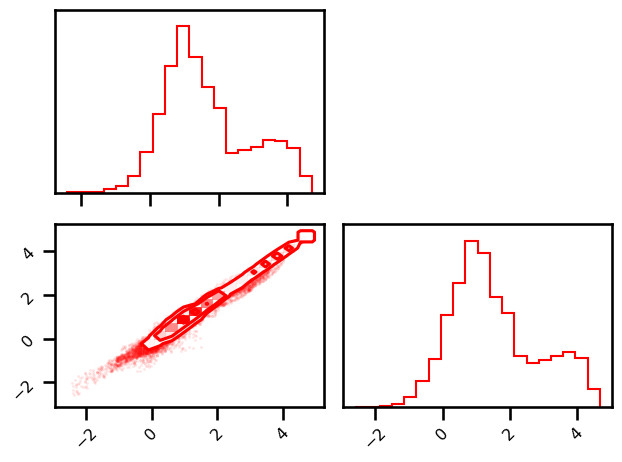

In [19]:
fig = plt.figure()
corner.corner(pixel_stack, smooth=0.1, fig=fig, color="Red", alpha=0.2)
plt.tight_layout()
plt.show()

In [20]:
da

<xarray.Dataset>
Dimensions:  (time: 41, lat: 199, lon: 199)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-01
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.15 -55.1 -55.05
  * lat      (lat) float64 33.05 33.1 33.15 33.2 33.25 ... 42.8 42.85 42.9 42.95
Data variables:
    ssh      (time, lat, lon) float64 [m] 0.646 0.6551 ... -0.1803 -0.1848
    psi      (time, lat, lon) float64 [m²/s] 6.335e+05 6.424e+05 ... -1.812e+05
    u        (time, lat, lon) float64 [m/s] 2.717 2.772 ... -0.03116 -0.1886
    v        (time, lat, lon) float64 [m/s] 2.032 1.757 1.635 ... -1.139 -1.012
    ke       (time, lat, lon) float64 [m²/s²] 5.757 5.385 4.43 ... 0.6488 0.5295
    vort_r   (time, lat, lon) float64 [] -16.18 -39.79 -36.06 ... 5.725 -14.51
    div      (time, lat, lon) float64 [] -73.25 -10.64 4.907 ... 13.27 69.32
    strain   (time, lat, lon) float64 [] 75.82 36.46 50.62 ... 31.56 25.92 63.8
Attributes:
    regrid_method:  bilinear

## Joint Densities

### NATL60 Simulation

In [21]:
pixel_stack = np.vstack([
    da_ref.ssh.mean(dim="time").values.ravel(),
    np.log(da_ref.ke.mean(dim="time").values.ravel()),
    da_ref.div.mean(dim="time").values.ravel(),
    da_ref.vort_r.mean(dim="time").values.ravel(),
    np.sqrt(da_ref.strain.mean(dim="time").values.ravel())
]).T

var_names = [
    "Sea Surface Height", "Log Kinetic Energy", "Divergence", "Relative Vorticity", "Strain Magnitude"
]

df = pd.DataFrame(data=pixel_stack, columns=var_names)

In [22]:
df.head()

,Sea Surface Height,Log Kinetic Energy,Divergence,Relative Vorticity,Strain Magnitude
0,0.584587,2.192933,0.700701,43.072588,8.935818
1,0.572537,2.064038,-1.159269,39.950690,9.164762
2,0.561261,1.972739,-4.000367,37.206583,9.032766
3,0.550573,1.924734,-5.941595,35.846746,8.905031
4,0.540427,1.893981,-4.480140,36.119179,9.017026


```python
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")

# Simulate data from a bivariate Gaussian
n = 10000
mean = [0, 0]
cov = [(2, .4), (.4, .2)]
rng = np.random.RandomState(0)
x, y = rng.multivariate_normal(mean, cov, n).T

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)
```

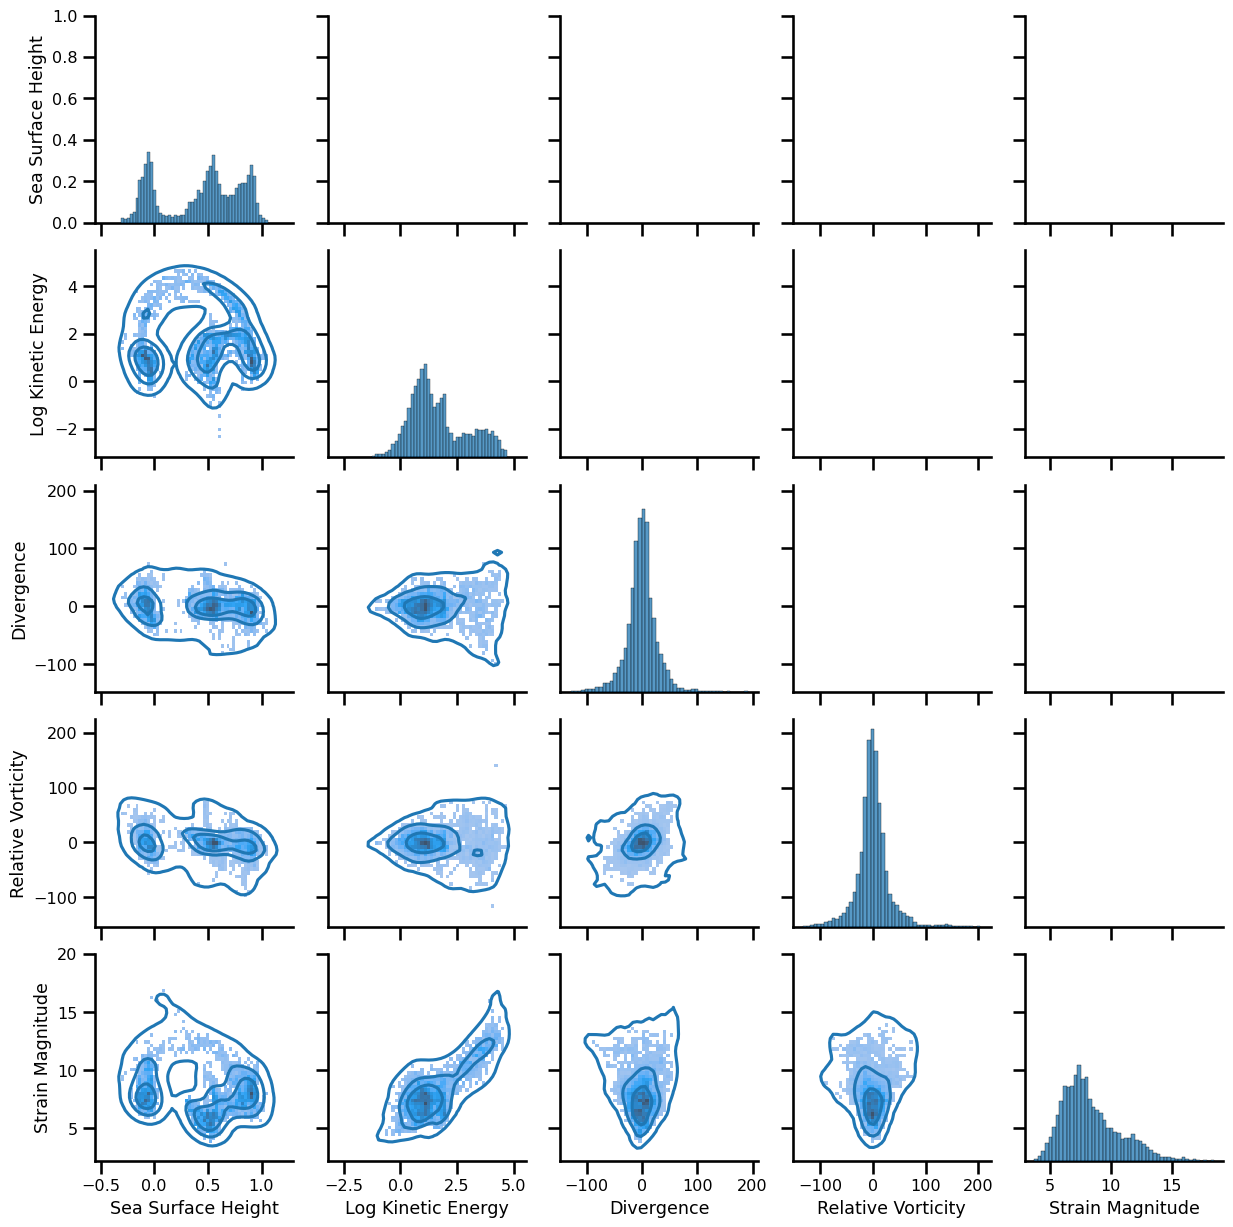

In [23]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(10_000))
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50)
g.map_lower(sns.histplot, bins=50, pthresh=.1)
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=.1)

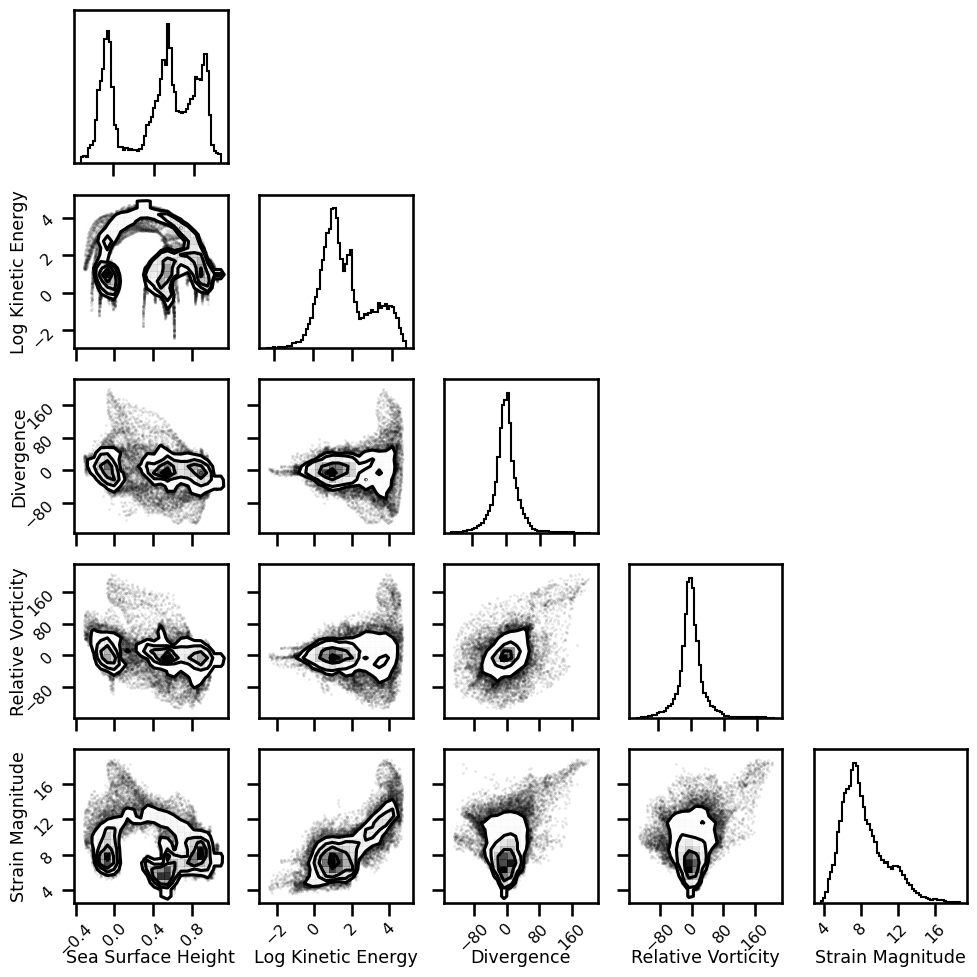

In [24]:
fig = plt.figure(figsize=(10,10))
corner.corner(df, fig=fig, labels=var_names, hist_bin_factor=3)
plt.tight_layout()
plt.show()

### Reconstruction

In [26]:
pixel_stack = np.vstack([
    da.ssh.mean(dim="time").values.ravel(),
    np.log(da.ke.mean(dim="time").values.ravel()),
    da.div.mean(dim="time").values.ravel(),
    da.vort_r.mean(dim="time").values.ravel(),
    np.sqrt(da.strain.mean(dim="time").values.ravel())
]).T

var_names = [
    "Sea Surface Height", "Log Kinetic Energy", "Divergence", "Relative Vorticity", "Strain Magnitude"
]

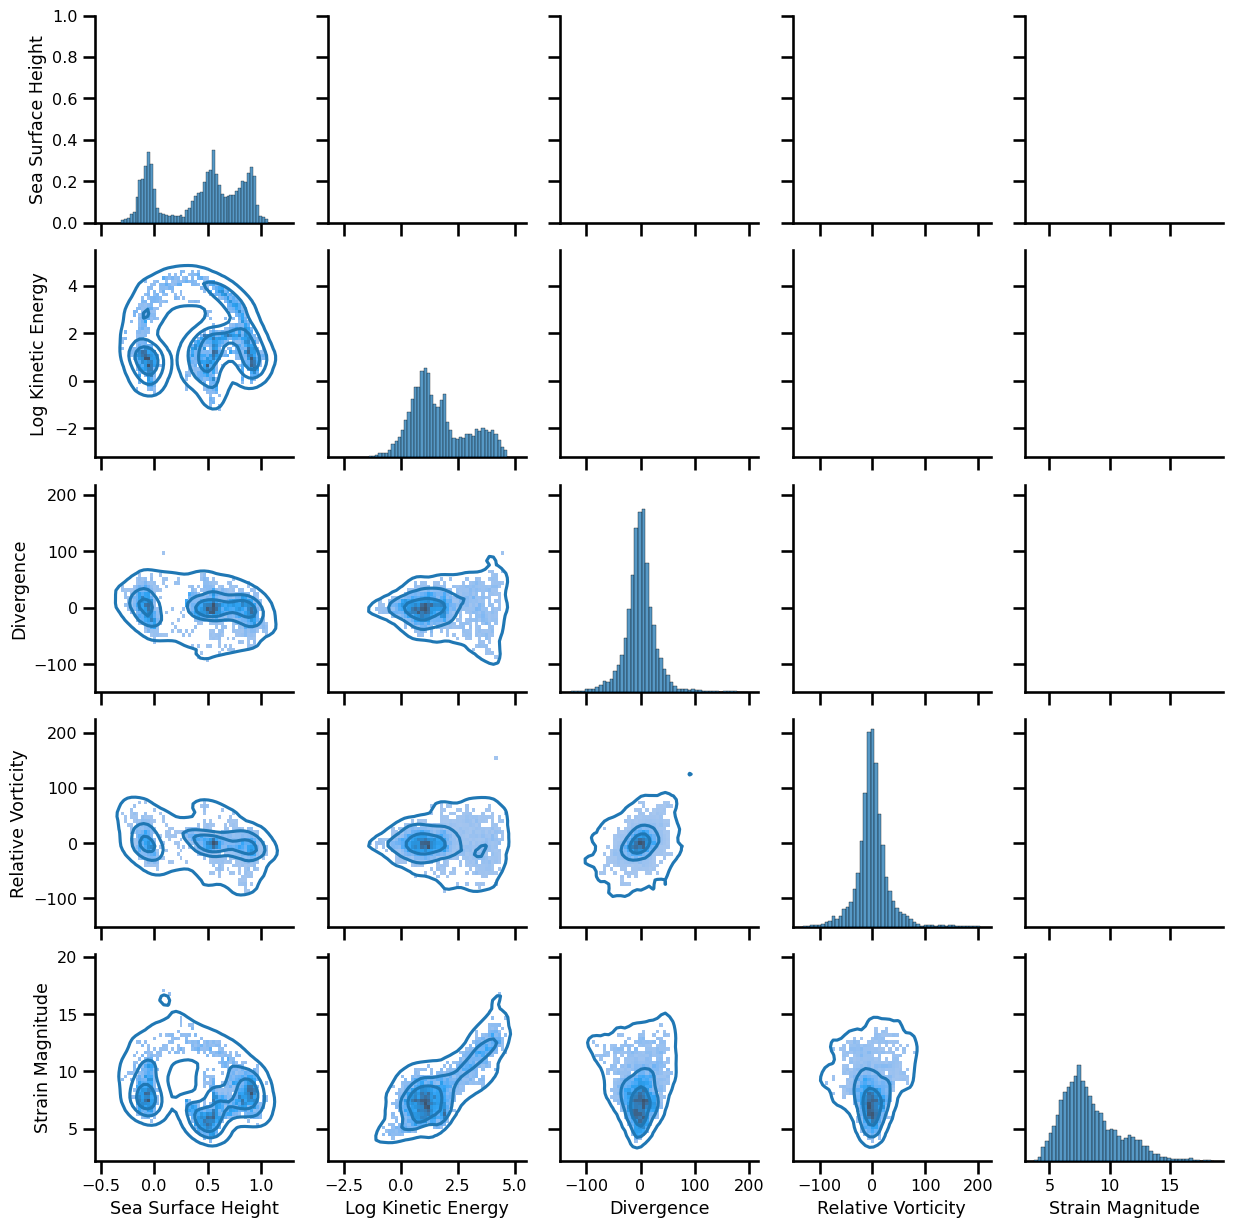

In [27]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(10_000))
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50)
g.map_lower(sns.histplot, bins=50, pthresh=.1)
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=.1)

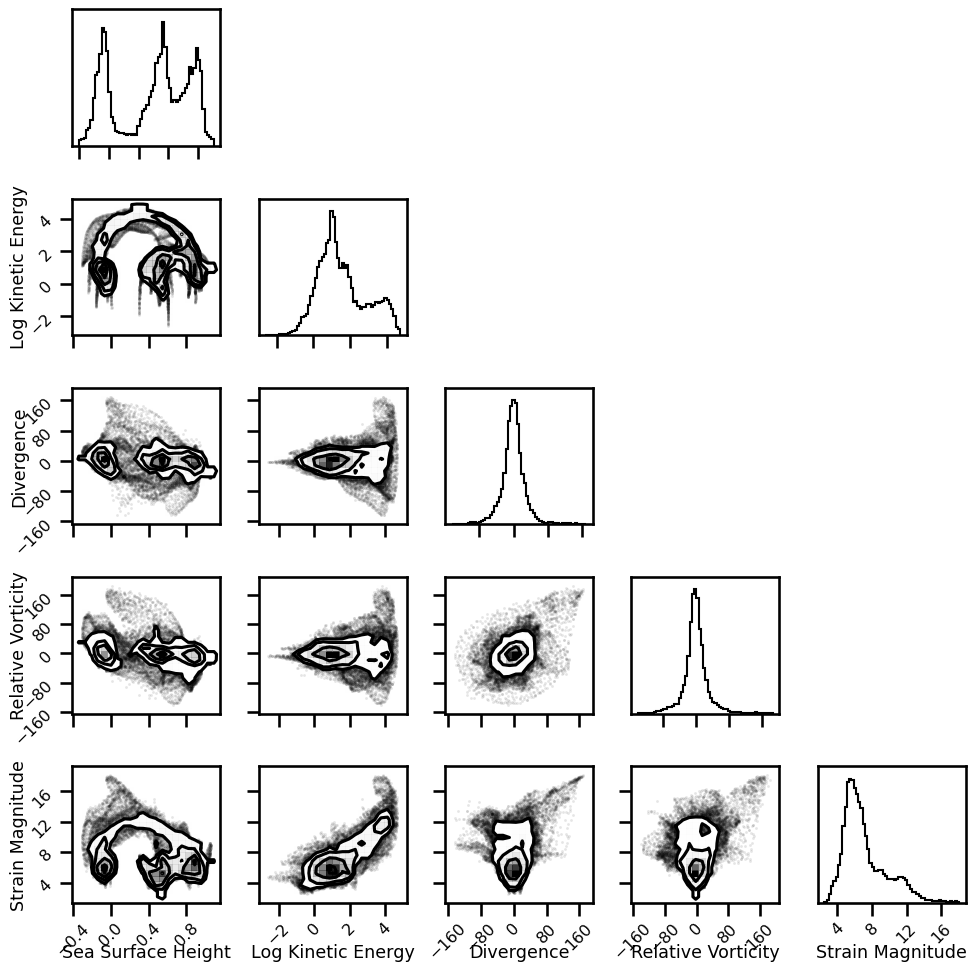

In [28]:
fig = plt.figure(figsize=(10,10))
corner.corner(pixel_stack, fig=fig, labels=var_names, hist_bin_factor=3)
plt.tight_layout()
plt.show()